# 🧠 Predicting Customer Churn Using Random Forests
Welcome to this practical machine learning exercise. In this notebook, you'll develop a solution for predicting customer churn — a classic and highly practical problem in economics, management, and business analytics.

**Goal:** Apply machine learning to identify customers at risk of leaving (churning), using historical data.

Along the way, you'll:
- Preprocess data responsibly (avoiding leakage)
- Train and evaluate models
- Build pipelines for cleaner workflows
- Tune models using validation sets
- Deploy a final product-ready solution

This notebook emphasizes **intuitive understanding**, **real-world practices**, and links to **further resources**.

**Note:** Documentation links are provided extensively, to help you, in the following format:
  - [📘 StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

**Note: Whenever you see the ✍️ symbol, it means you must fill in the blanks with your own code!**

## ⚙️ Step 0: Setup

Before we begin, we load the core Python libraries used for:
- **Data manipulation** (`pandas`, `numpy`)
- **Visualization** (`matplotlib`, `seaborn`)
- **Modeling and preprocessing** (`sklearn`)

We'll also be using the **scikit-learn** machine learning library throughout this notebook — make sure to check the documentation links provided at each step.

In [1]:
# Common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

## 📊 Step 1: Load the Data

The dataset contains customer data from a (fictional) telecom company. Each row is a customer, and each column is an attribute describing that customer’s usage patterns or account features.

You are given a **train set** and a **test set** (pre-split). This setup simulates a situation where you're developing a model using historical data and then testing how well it might generalize to new customers.

In [2]:
# Load data
# ✍️ Load the the training set into df_train and the test set into df_test.
df_train = pd.read_csv('churn_train.csv')
df_test = pd.read_csv('churn_test.csv')
df_train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 🎯 Step 2: Understand the Problem — Classification
This is a **binary classification problem**: each customer either **churns** (`Churn = Yes`) or **stays** (`Churn = No`).

**Class imbalance:** Only ~14% of customers are churners. This will affect how we train and evaluate the model.

📌 We'll address this through evaluation metrics like precision and recall.

In [3]:
# Separate features and target
# ✍️ Split df_train into X_train and y_train; do the same for df_test.
X_train = df_train.drop("Churn", axis=1)
y_train = df_train["Churn"]

X_test = df_test.drop("Churn", axis=1)
y_test = df_test["Churn"]

## 🧹 Step 3: Preprocessing — Manual (Leakage-Free)

Preprocessing is where most real-world ML effort goes. We must:
1. Encode **categorical** features numerically (for the model).
2. Scale **numerical** features to help model convergence.
3. Avoid **data leakage**: Never use information from the test set to preprocess the training set!

📌 We'll handle categorical and numeric features **separately** and then combine them.

In [4]:
# Identify feature types
# ✍️ Create a list variable named categorical_features, containing the names of all categorical feature columns.
# ✍️ Create a list variable named numeric_features, containing the names of all numeric feature columns.
categorical_features = ["State", "Area code", "International plan", "Voice mail plan"]
numeric_features = [col for col in X_train.columns if col not in categorical_features]

In [5]:
# Manual preprocessing
# ✍️ Fit a OneHotEncoder to the training set, but apply it to both the training and test set!
# 💡 Hint: Recall the difference between the `fit`, `transform` and `fit_transform` methods.
# ❗ Important! Use `sparse=False` or `sparse_output=False` (depending on the version of sklearn you're using)
# when initializing your OneHotEncoder! It will be important later!
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train[categorical_features])
X_train_cat = ohe.transform(X_train[categorical_features])
X_test_cat = ohe.transform(X_test[categorical_features])

# ✍️ Now fit a StandardScaler to the training set, but apply it to both the training and test set!
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])
X_train_num = scaler.transform(X_train[numeric_features])
X_test_num = scaler.transform(X_test[numeric_features])

In [6]:
# We now combine the numerical and categorical features:
# ℹ️ This wouldn't have worked without `sparse=False`!
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])

🎓 **Why this matters**:

- **StandardScaler** rescales features to mean 0 and standard deviation 1, making tree-based models faster and more robust.
  - [📘 StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

- **OneHotEncoder** converts categorical variables into binary vectors.
  - [📘 OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

✍️ **Your Turn**: Combine the categorical and numeric processed arrays with `np.hstack(...)` to get `X_train_final` and `X_test_final`.

## 🌲 Step 4: Random Forest Training

**Random Forests** are one of the most versatile and powerful classifiers, especially for tabular data.

They are:
- **Ensemble models** made of many decision trees.
- Resistant to overfitting thanks to randomness.
- Handle both categorical (after encoding) and numeric features well.

[📘 RandomForestClassifier Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [7]:
# Train a Random Forest classifier
# ✍️ Create a new RandomForestClassifier and assign it the a variable named `model`.
# ✍️ Fit your RandomForestClassifier in the training set.
model = RandomForestClassifier(random_state=42)
model.fit(X_train_final, y_train)

RandomForestClassifier(random_state=42)

## 📊 Step 5: Evaluation on Held-Out Test Set

To estimate how well your model might perform in production, use a **test set that the model hasn’t seen**.

Use:
- [📘 accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [📘 classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

📌 **Reminder**: With class imbalance, accuracy can be misleading. Look at **precision, recall, and F1 score** as well.

In [8]:
# Evaluate on test set
# ✍️ Save the prediction of your model on the test set to `y_pred`.
y_pred = model.predict(X_test_final)
# ✍️ Print the accuracy score your model got.
print("Accuracy:", accuracy_score(y_test, y_pred))
# ✍️ Print a classification report for your model.
print(classification_report(y_test, y_pred))

Accuracy: 0.9445277361319341
              precision    recall  f1-score   support

       False       0.94      0.99      0.97       572
        True       0.95      0.64      0.77        95

    accuracy                           0.94       667
   macro avg       0.95      0.82      0.87       667
weighted avg       0.94      0.94      0.94       667



## 🔁 Step 6: Use Pipelines

Manual preprocessing is error-prone. Use [📘 Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to:

- Bundle preprocessing and modeling together.
- Reduce leakage risk.
- Improve reproducibility.

We'll use [📘 ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply different preprocessing to numeric and categorical features.

📚 Read more:
- [📘 sklearn Pipelines Tutorial](https://scikit-learn.org/stable/modules/compose.html)
- [📝 Blog Post](https://towardsdatascience.com/how-to-use-columntransformer-for-numerical-and-categorical-data-6d8cbd25f4b6)

In [9]:
# Use sklearn pipeline
# ✍️ Create a ColumnTransformer object, made up of a StandardScaler followed by a OneHotEncoder object.
#❗ Important! Remember to use `sparse=False` or `sparse_output=False`.
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

# ✍️ Now create a Pipeline object made up of your column transformer object and a RandomForestClassifier object.
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

# ✍️ Fit your pipeline object on the training set, then predict results for the test set
# and produce a classification report.
pipeline.fit(X_train, y_train)
y_pred_pipe = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_pipe))

              precision    recall  f1-score   support

       False       0.94      0.99      0.97       572
        True       0.95      0.64      0.77        95

    accuracy                           0.94       667
   macro avg       0.95      0.82      0.87       667
weighted avg       0.94      0.94      0.94       667



In [10]:
preprocessor['cat']

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [11]:
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Account length',
                                                   'Number vmail messages',
                                                   'Total day minutes',
                                                   'Total day calls',
                                                   'Total day charge',
                                                   'Total eve minutes',
                                                   'Total eve calls',
                                                   'Total eve charge',
                                                   'Total night minutes',
                                                   'Total night calls',
                                                   'Total night charge',
                                                   'Total intl minutes',
                                                   'Total intl calls',
                                                   'Total intl charge',
                                                   'Customer service calls']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['State', 'Area code',
                                                   'International plan',
                                                   'Voice mail plan'])])),
                ('rf', RandomForestClassifier(random_state=42))])

In [12]:
pipeline['preprocess']

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Account length', 'Number vmail messages',
                                  'Total day minutes', 'Total day calls',
                                  'Total day charge', 'Total eve minutes',
                                  'Total eve calls', 'Total eve charge',
                                  'Total night minutes', 'Total night calls',
                                  'Total night charge', 'Total intl minutes',
                                  'Total intl calls', 'Total intl charge',
                                  'Customer service calls']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['State', 'Area code', 'International plan',
                                  'Voice mail plan'])])

## 🔍 Step 7: Manual Hyperparameter Tuning

To make better models, tune key hyperparameters. We’ll try different values for `max_depth`.

We'll use a **train-validation-test** split:
- **Train**: build models
- **Validation**: compare models
- **Test**: final performance estimate

[📘 train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [13]:
# Let's unite the training and validation sets into one big set:
df_full = pd.concat([df_train, df_test], ignore_index=True)
X = df_full.drop("Churn", axis=1)
y = df_full["Churn"]

In [14]:
# Train-validation-test split for tuning
# We use train_test_split to get a three-way split: Firstg into trainval and test;
# then we split trainval into train and validation.
X_trainval, X_test_final, y_trainval, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

In [15]:
# Manual hyperparameter tuning
# ✍️ Manually find the best value for the max_depth hyperparameter out of [5, 10, 15, 20]:
# 💡 Hint: Use a for loop to iterate over a list of possible values. Then, for each such value,
# create a new pipeline with the appropriate value for RandomForestClassifier (you DON'T have to
# create your ColumnTransformer again; use the same object you've already created), fit it on the
# training set and evaluate it on the **validation set**! Do NOT touch the test set in this loop!

depths = [5, 10, 20, None]
for d in depths:
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('rf', RandomForestClassifier(max_depth=d, random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    val_preds = pipeline.predict(X_val)
    print(f"Max Depth: {d}")
    print(classification_report(y_val, val_preds))
    print("-" * 40)

Max Depth: 5
              precision    recall  f1-score   support

       False       0.87      1.00      0.93       570
        True       0.93      0.14      0.25        97

    accuracy                           0.87       667
   macro avg       0.90      0.57      0.59       667
weighted avg       0.88      0.87      0.83       667

----------------------------------------
Max Depth: 10
              precision    recall  f1-score   support

       False       0.92      1.00      0.96       570
        True       0.96      0.52      0.67        97

    accuracy                           0.93       667
   macro avg       0.94      0.76      0.81       667
weighted avg       0.93      0.93      0.92       667

----------------------------------------
Max Depth: 20
              precision    recall  f1-score   support

       False       0.94      1.00      0.97       570
        True       0.98      0.64      0.78        97

    accuracy                           0.95       667
   ma

## ✅ Step 8: Final Evaluation and Deployment-Ready Model

After choosing the best hyperparameter from the validation set, retrain your model on **train+val** and evaluate on **test**.

Then, retrain a final version on **all labeled data** to use in production.

You can save the model for future use using:
[📘 sklearn model persistence](https://scikit-learn.org/stable/model_persistence.html)

### 8.1: Final Evaluation

In [16]:
# Final model evaluation
# ✍️ Now create the pipeline again, now with max_depth set to the value which showed the
# best results. Then, fit it on the **X_trainval** set, and predict on the test set.
# What is the model performance? That's our estimate for future performamce.
best_depth = 10  # Replace with chosen value
pipeline_final = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(max_depth=best_depth, random_state=42))
])
pipeline_final.fit(X_trainval, y_trainval)
test_preds = pipeline_final.predict(X_test_final)
print(classification_report(y_test_final, test_preds))

              precision    recall  f1-score   support

       False       0.91      1.00      0.95       570
        True       0.98      0.43      0.60        97

    accuracy                           0.92       667
   macro avg       0.94      0.72      0.78       667
weighted avg       0.92      0.92      0.90       667



### 💬 Answer the following questions:
- Are there more false positives or false negatives?
- Which mistake is more costly in your business scenario?
- Should you tune the model to favor precision or recall?

### 🧪 Sub-Task: Plot the Confusion Matrix

The **confusion matrix** helps you visually assess where your model is getting things right or wrong.

It breaks predictions into:
- **True Positives (TP)**: correctly predicted churners.
- **True Negatives (TN)**: correctly predicted non-churners.
- **False Positives (FP)**: predicted churn but customer stayed.
- **False Negatives (FN)**: predicted stay but customer churned.

This can help you **understand your model's trade-offs**, especially when classifying rare events (like churn).

📘 Documentation:
- [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [sklearn.metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

✍️ **Your task**: Use `ConfusionMatrixDisplay.from_predictions(...)` to plot the matrix.

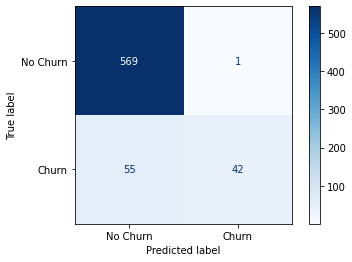

In [17]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_final, test_preds,
    display_labels=["No Churn", "Churn"],
    cmap="Blues"
)

### 8.2: Train the final model

In [18]:
# Train final product-ready model
# ✍️ Now create the pipeline again, one last time. Fit it on the entire dataset (X and y variables).
# That's it! You're done! Great job!
final_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(max_depth=best_depth, random_state=42))
])
final_pipeline.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Account length',
                                                   'Number vmail messages',
                                                   'Total day minutes',
                                                   'Total day calls',
                                                   'Total day charge',
                                                   'Total eve minutes',
                                                   'Total eve calls',
                                                   'Total eve charge',
                                                   'Total night minutes',
                                                   'Total night calls',
                                                   'Total night charge',
                                                   'Total intl minutes',
                                                   'Total intl calls',
                                                   'Total intl charge',
                                                   'Customer service calls']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['State', 'Area code',
                                                   'International plan',
                                                   'Voice mail plan'])])),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

In [19]:
import pickle

In [25]:
with open('my_pipline.pkl', 'wb') as f:
    pickle.dump(final_pipeline, f)

In [29]:
with open('my_pipline.pkl', 'rb') as f:
    prod_pipeline = pickle.load(f)

In [30]:
prod_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Account length',
                                                   'Number vmail messages',
                                                   'Total day minutes',
                                                   'Total day calls',
                                                   'Total day charge',
                                                   'Total eve minutes',
                                                   'Total eve calls',
                                                   'Total eve charge',
                                                   'Total night minutes',
                                                   'Total night calls',
                                                   'Total night charge',
                                                   'Total intl minutes',
                                                   'Total intl calls',
                                                   'Total intl charge',
                                                   'Customer service calls']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['State', 'Area code',
                                                   'International plan',
                                                   'Voice mail plan'])])),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])